Just a general notebook for unzipping the data and exploring it

Add a shortcut of the drive to your main drive

In [1]:
# so notebook can access the folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# this is to unzip the tar into the drive
# I commented this out so we won't unzip twice
#!tar -xzvf /content/drive/MyDrive/DS565_Project/IEMOCAP_full_release.tar.gz -C /content/drive/MyDrive/DS565_Project

Streaming output truncated to the last 5000 lines.
./IEMOCAP_full_release/Session1/sentences/ForcedAlignment/Ses01F_script01_2/._Ses01F_script01_2_F002.phseg
./IEMOCAP_full_release/Session1/sentences/ForcedAlignment/Ses01F_script01_2/Ses01F_script01_2_F002.phseg
./IEMOCAP_full_release/Session1/sentences/ForcedAlignment/Ses01F_script01_2/._Ses01F_script01_2_F002.stseg
./IEMOCAP_full_release/Session1/sentences/ForcedAlignment/Ses01F_script01_2/Ses01F_script01_2_F002.stseg
./IEMOCAP_full_release/Session1/sentences/ForcedAlignment/Ses01F_script01_2/._Ses01F_script01_2_F002.syseg
./IEMOCAP_full_release/Session1/sentences/ForcedAlignment/Ses01F_script01_2/Ses01F_script01_2_F002.syseg
./IEMOCAP_full_release/Session1/sentences/ForcedAlignment/Ses01F_script01_2/._Ses01F_script01_2_F002.wdseg
./IEMOCAP_full_release/Session1/sentences/ForcedAlignment/Ses01F_script01_2/Ses01F_script01_2_F002.wdseg
./IEMOCAP_full_release/Session1/sentences/ForcedAlignment/Ses01F_script01_2/._Ses01F_script01_2_F003.

BRO TOOK AN HOUR TO UNZIP JESUS

EDA

In [2]:
data_path = '/content/drive/MyDrive/DS565_Project/IEMOCAP_full_release'

The folders are made in this format:

```
- IEMOCAP_full_release
  - SessionX (replace X with number 1-5)
    - dialog (files split by full dialogues- mix of sentences)
      - EmoEvaluation (eval texts)
      - avi (video files)
      - wav files (audio files)
    - sentences (files split by sentence)
      - wav (audio files)
        - SesX[F/M]_improvN.wav
```

Folder size: 17GB

Split to train and test

To allow for training outside datasets, we downsample the labels to:
- neutral
- happy
- sad


In [3]:
import os

# getting all lists of evaluations in each session
sessions = os.listdir(data_path)

total_evals = []
for s in sessions:
  if 'Session' not in s or s.startswith('._'):
    continue
  eval_path = os.path.join(data_path, s, 'dialog', 'EmoEvaluation')
  #sentences = os.path.join(data_path, s, 'sentences')
  evals = [f for f in os.listdir(eval_path) if f.endswith('.txt') and not f.startswith('.')]
  evals = [os.path.join(eval_path, f) for f in evals]
  total_evals.extend(evals)


total_evals[:3]

['/content/drive/MyDrive/DS565_Project/IEMOCAP_full_release/Session2/dialog/EmoEvaluation/Ses02F_impro07.txt',
 '/content/drive/MyDrive/DS565_Project/IEMOCAP_full_release/Session2/dialog/EmoEvaluation/Ses02F_impro04.txt',
 '/content/drive/MyDrive/DS565_Project/IEMOCAP_full_release/Session2/dialog/EmoEvaluation/Ses02M_impro08.txt']

In [4]:
len(total_evals)

151

In [5]:
from collections import defaultdict
labels = defaultdict(tuple)
unique_emotions = defaultdict(int)

for f in total_evals:
  with open(f, 'r') as f_in:
    lines = f_in.read().split('\n\n')[1:]

  for snippet in lines:
    if not snippet:
      continue
    rows = snippet.split('\n')

    # from first row, extract:
    # [START_TIME - END_TIME] TURN_NAME EMOTION
    first_row = rows[0].split('\t')
    time = first_row[0]
    filename = first_row[1]
    emotion = first_row[2]
    # get session number
    session = os.path.split(os.path.split(os.path.split(os.path.split(f)[0])[0])[0])[1]
    improv_script = filename[:-5]

    labels[filename] = (time, emotion, session, improv_script)
    unique_emotions[emotion] += 1

print(unique_emotions)

defaultdict(<class 'int'>, {'xxx': 2507, 'exc': 1041, 'neu': 1708, 'hap': 595, 'fru': 1849, 'sad': 1084, 'fea': 40, 'sur': 107, 'ang': 1103, 'oth': 3, 'dis': 2})


In [6]:
sorted(unique_emotions.items(), key=lambda x: -x[1])

[('xxx', 2507),
 ('fru', 1849),
 ('neu', 1708),
 ('ang', 1103),
 ('sad', 1084),
 ('exc', 1041),
 ('hap', 595),
 ('sur', 107),
 ('fea', 40),
 ('oth', 3),
 ('dis', 2)]

In [7]:
len(labels)

10039

## Emotion Mapping

In [ ]:
emo_map = {i:emo for i, emo in enumerate(sorted(unique_emotions.keys()))}
emo_map

{0: 'ang',
 1: 'dis',
 2: 'exc',
 3: 'fea',
 4: 'fru',
 5: 'hap',
 6: 'neu',
 7: 'oth',
 8: 'sad',
 9: 'sur',
 10: 'xxx'}

In [ ]:
import json

with open('/content/drive/MyDrive/DS565_Project/metadata.json', 'w') as f:
  json.dump(labels, f, indent=4)

with open('/content/drive/MyDrive/DS565_Project/label_mapping.json', 'w') as f:
  json.dump(emo_map, f, indent=4)

Average length of videos

In [ ]:
import json

with open('/content/drive/MyDrive/DS565_Project/metadata.json', 'r') as f_in:
  labels = json.load(f_in)

with open('/content/drive/MyDrive/DS565_Project/label_mapping.json', 'r') as f_in:
  emo_map = json.load(f_in)


len(labels)

10039

In [ ]:
import numpy as np

timestamps = [val[0] for val in labels.values()]
durations = [0] * len(timestamps)

for i in range(len(timestamps)):
  left, right = timestamps[i].split(' - ')
  left = float(left[1:])
  right = float(right[:-1])
  durations[i] = right-left

np.mean(durations)

4.460108994919813

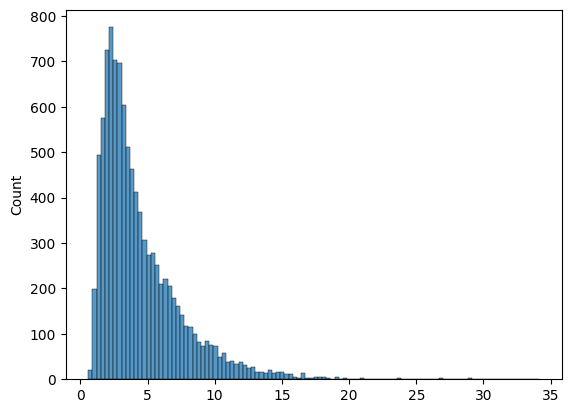

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(durations)
plt.show()

Split to train-test

In [ ]:
!pip install scikit-learn

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

reverse_map = {v:k for k,v in emo_map.items()}

filenames = np.array(list(labels.keys()))
y = np.array([reverse_map[val[1]] for val in labels.values()])

X_train, X_test, y_train, y_test = train_test_split(filenames, y, test_size=0.2, stratify = y, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify = y_train,random_state=RANDOM_STATE)

print(
    len(X_train),
    len(X_val),
    len(X_test)
)

6023 2008 2008


In [ ]:
train = np.vstack((X_train, y_train)).T
val = np.vstack((X_val, y_val)).T
test = np.vstack((X_test, y_test)).T

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train, columns = ['name', 'emotion'])
val_df = pd.DataFrame(val, columns = ['name', 'emotion'])
test_df = pd.DataFrame(test, columns = ['name', 'emotion'])

train_df.to_csv('/content/drive/MyDrive/DS565_Project/train.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/DS565_Project/val.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/DS565_Project/test.csv', index=False)

train_df.head()

,name,emotion
0,Ses02M_impro08_M013,6
1,Ses01M_impro02_M012,8
2,Ses04F_script03_2_M020,10
3,Ses04F_script01_1_F042,0
4,Ses05M_script03_2_M016,4
